# **IMPORTS & UTILS**

In [ ]:
from google.colab import drive 
import os
drive.mount('/content/drive')
path = "/content/drive/MyDrive/NLP_PROJECT/"

if not os.path.exists(path):
    os.mkdir(path)

if not os.path.exists(path+"/cache/"):
    os.mkdir(path+"/cache/")

os.chdir(path)

Mounted at /content/drive


In [ ]:
import nltk, math, torch

import matplotlib.pyplot as plt
from collections import namedtuple
from nltk.corpus import brown
import numpy as np

from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import numpy as np

from utils import *

## **Corpus Initializations**

In [ ]:
def init_brown():
    nltk.download('brown')
    words = brown.words(categories=(brown.categories()))
    N     = len(words)

    words_test  = words[0:math.ceil(N*0.7)]
    words_train = words[math.ceil(N*0.7):math.ceil(N*0.9)]
    words_val   = words[math.ceil(N*0.9):]

    f=open('test.txt','w')
    for w in words_test:
        f.write(w+" ")
    f.close()

    f=open('train.txt','w')
    for w in words_train:
        f.write(w+" ")
    f.close()

    f=open('valid.txt','w')
    for w in words_val:
        f.write(w+" ")
    f.close()

## Data preprocess

In [ ]:
num_char = 0
def preprocess(): 
    global num_char
    word_dict, char_dict = create_word_char_dict("valid.txt", "train.txt", "test.txt")
    num_words = len(word_dict)
    num_char  = len(char_dict)
    char_dict["BOW"] = num_char+1
    char_dict["EOW"] = num_char+2
    char_dict["PAD"] = 0
    
    #  dict of (int, string)
    reverse_word_dict = {value:key for key, value in word_dict.items()}
    max_word_len = max([len(word) for word in word_dict])

    objects = {
        "word_dict": word_dict,
        "char_dict": char_dict,
        "reverse_word_dict": reverse_word_dict,
        "max_word_len": max_word_len
    }
    
    torch.save(objects, "cache/prep_"+corpus+".pt")
    print("Preprocess done.")

## Dataset prep

In [ ]:
def dataset_prep():
    train_text = read_data("train.txt")
    valid_text = read_data("valid.txt")
    test_text  = read_data("test.txt")

    train_set = np.array(text2vec(train_text, char_dict, max_word_len))
    valid_set = np.array(text2vec(valid_text, char_dict, max_word_len))
    test_set  = np.array(text2vec(test_text,  char_dict, max_word_len))

    # Labels are next-word index in word_dict with the same length as inputs
    train_label = np.array([word_dict[w] for w in train_text[1:]] + [word_dict[train_text[-1]]])
    valid_label = np.array([word_dict[w] for w in valid_text[1:]] + [word_dict[valid_text[-1]]])
    test_label  = np.array([word_dict[w] for w in test_text[1:]] + [word_dict[test_text[-1]]])

    category = {"tdata":train_set, "vdata":valid_set, "test": test_set, 
                "trlabel":train_label, "vlabel":valid_label, "tlabel":test_label}
    torch.save(category, "cache/data_sets_"+corpus+".pt") 

## Training loop

### LSTM

In [ ]:
def train_LSTM(net, data, opt, model_name):
    global results
    torch.manual_seed(1024)

    train_input = torch.from_numpy(data.train_input)
    train_label = torch.from_numpy(data.train_label)
    valid_input = torch.from_numpy(data.valid_input)
    valid_label = torch.from_numpy(data.valid_label)

    L = opt.seq_len

    # [num_seq, seq_len, max_word_len+2]
    num_seq = train_input.size()[0] //  L
    train_input = train_input[:num_seq* L, :]
    train_input = train_input.view(-1,  L, opt.max_word_len+2)

    num_seq = valid_input.size()[0] //  L
    valid_input = valid_input[:num_seq* L, :]
    valid_input = valid_input.view(-1,  L, opt.max_word_len+2)

    num_epoch = opt.epochs
    num_iter_train = train_input.size()[0] // opt.batch_size
    
    learning_rate = opt.init_lr
    old_PPL = 100000
    best_PPL = 100000

    n_stuck = 0

    # Log-SoftMax
    criterion = nn.CrossEntropyLoss()
    
    # word_emb_dim == hidden_size / num of hidden units 
    hidden = (to_var(torch.zeros(2,  opt.batch_size, opt.word_embed_dim)), 
              to_var(torch.zeros(2,  opt.batch_size, opt.word_embed_dim)))

    for epoch in range(num_epoch):
        ################  Validation  ####################
        net.eval()
        loss_batch = []
        PPL_batch  = []
        num_iter_valid = valid_input.size()[0] // opt.batch_size


        # TRANSFORMER :
        # VALID  : S+L sequences
        # LABELS : S+L labels of next words -> use the (-L,1) labels
        
        valid_generator  = batch_generator(valid_input, opt.batch_size)
        vlabel_generator = batch_generator(valid_label, opt.batch_size*L)

        for t in range(num_iter_valid):
            batch_input = valid_generator.__next__()  # (N,L,W)
            batch_label = vlabel_generator.__next__() # (N*L)

            ####################################################################

            hidden = [state.detach() for state in hidden]
            valid_output, hidden = net(to_var(batch_input), hidden)
            ####################################################################

            length = valid_output.size()[0]

            # [num_sample-1, len(word_dict)] vs [num_sample-1]

            valid_loss = criterion(valid_output, to_var(batch_label))

            PPL = torch.exp(valid_loss.data)

            loss_batch.append(float(valid_loss))
            PPL_batch.append(float(PPL))

        PPL = np.mean(PPL_batch)
        print("[epoch {}] valid PPL={}".format(epoch, PPL))
        print("valid loss={}".format(np.mean(loss_batch)))
        print("PPL decrease={}".format(float(old_PPL - PPL)))

        # UPDATE RESULTS DICT
        if results.get(model_name) == None:
            results[model_name] = {"validation":{"loss":[],"PPL":[]},"training":{"loss":[],"PPL":[]}}
        results[model_name]["validation"]["loss"].append(np.mean(loss_batch))
        results[model_name]["validation"]["PPL"].append(PPL)

        # Preserve the best model
        if best_PPL > PPL:
            best_PPL = PPL
            torch.save(net.state_dict(), "cache/"+model_name+".pt")
            torch.save(net, "cache/"+model_name+"_net.pkl")

        # Adjust the learning rate
        if float(old_PPL - PPL) <= 1.0 and n_stuck > 5:
            learning_rate /= 10
            print("halved lr:{}".format(learning_rate))
            n_stuck = 0
        elif float(old_PPL - PPL) <= 1.0:
            n_stuck += 1

        old_PPL = PPL

        ##################################################
        #################### Training ####################
        net.train()

        optimizer  = optim.Adam(net.parameters(), 
                               lr = learning_rate)

        # split the first dim
        input_generator = batch_generator(train_input, opt.batch_size)
        label_generator = batch_generator(train_label, opt.batch_size*L)

        total_loss, total_PPL = 0, 0

        for t in range(num_iter_train):

            if t % 100 == 0:
                print(f"{t}/{num_iter_train}")

            batch_input = input_generator.__next__()
            batch_label = label_generator.__next__()
            ####################################################################

            # detach hidden state of LSTM from last batch
            hidden = [state.detach() for state in hidden]
            
            ####################################################################

            output, hidden = net(to_var(batch_input), hidden)
            # [num_word, vocab_size]
            ####################################################################
            loss = criterion(output, to_var(batch_label))

            net.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm(net.parameters(), 5, norm_type=2)
            optimizer.step()

            total_loss += loss.cpu().data
            total_PPL  += np.exp(loss.cpu().data)
          
        total_loss /= num_iter_train 
        total_PPL  /= num_iter_train 
    
        results[model_name]["training"]["loss"].append(total_loss)
        results[model_name]["training"]["PPL"].append(total_PPL)

        print(f"Train loss : {total_loss}")
        print(f"Train PPL : {total_PPL}")

    torch.save(net.state_dict(), "cache/"+model_name+".pt")
    print("Training finished.")

### Transformer

In [ ]:
def train_Transformer(net, data, opt, model_name):
    global results
    torch.manual_seed(1024)

    train_input = torch.from_numpy(data.train_input)
    train_label = torch.from_numpy(data.train_label)
    valid_input = torch.from_numpy(data.valid_input)
    valid_label = torch.from_numpy(data.valid_label)

    L = opt.seq_len

    # [num_seq, seq_len, max_word_len+2]
    num_seq = train_input.size()[0] //  L
    train_input = train_input[:num_seq* L, :]
    train_input = train_input.view(-1,  L, opt.max_word_len+2)

    num_seq = valid_input.size()[0] //  L
    valid_input = valid_input[:num_seq* L, :]
    valid_input = valid_input.view(-1,  L, opt.max_word_len+2)

    num_epoch = opt.epochs
    num_iter_train = train_input.size()[0] // opt.batch_size
    
    learning_rate = opt.init_lr
    old_PPL = 100000
    best_PPL = 100000

    n_stuck = 0

    # Log-SoftMax
    criterion = nn.CrossEntropyLoss()
    
    X = torch.zeros((opt.batch_size,L,opt.max_word_len+2)).long().cuda()

    for epoch in range(num_epoch):
        ################  Validation  ####################
        net.eval()
        loss_batch = []
        PPL_batch  = []
        num_iter_valid = valid_input.size()[0] // opt.batch_size


        # TRANSFORMER :
        # VALID  : S+L sequences
        # LABELS : S+L labels of next words -> use the (-L,1) labels
        
        valid_generator  = batch_generator(valid_input, opt.batch_size)
        vlabel_generator = batch_generator(valid_label, opt.batch_size*L)

        for t in range(num_iter_valid):
            batch_input = valid_generator.__next__()  # (N,L,W)
            batch_label = vlabel_generator.__next__() # (N*L)

            ####################################################################
            y_input  = batch_input[:,:,:].cuda()
            batch_label = torch.reshape(batch_label,(opt.batch_size,L)).cuda()
            y_pred      = batch_label[:,:].cuda().reshape(-1)
            
            ####################################################################
            valid_output = net(X,y_input)

            ####################################################################

            ####
            X = y_input
            ####

            length = valid_output.size()[0]

            # [num_sample-1, len(word_dict)] vs [num_sample-1]
            valid_loss = criterion(valid_output, to_var(y_pred))

            PPL = torch.exp(valid_loss.data)

            loss_batch.append(float(valid_loss))
            PPL_batch.append(float(PPL))

        PPL = np.mean(PPL_batch)
        print("[epoch {}] valid PPL={}".format(epoch, PPL))
        print("valid loss={}".format(np.mean(loss_batch)))
        print("PPL decrease={}".format(float(old_PPL - PPL)))

        # UPDATE RESULTS DICT
        if results.get(model_name) == None:
            results[model_name] = {"validation":{"loss":[],"PPL":[]},"training":{"loss":[],"PPL":[]}}
        results[model_name]["validation"]["loss"].append(np.mean(loss_batch))
        results[model_name]["validation"]["PPL"].append(PPL)

        # Preserve the best model
        if best_PPL > PPL:
            best_PPL = PPL
            torch.save(net.state_dict(), "cache/"+model_name+".pt")
            torch.save(net, "cache/"+model_name+"_net.pkl")

        # Adjust the learning rate
        if float(old_PPL - PPL) <= 1.0 and n_stuck > 5:
            learning_rate /= 10
            print("halved lr:{}".format(learning_rate))
            n_stuck = 0
        elif float(old_PPL - PPL) <= 1.0:
            n_stuck += 1

        old_PPL = PPL

        ##################################################
        #################### Training ####################
        net.train()

        X = torch.zeros((opt.batch_size,L,opt.max_word_len+2)).long().cuda()

        optimizer  = optim.Adam(net.parameters(), 
                               lr = learning_rate)

        # split the first dim
        input_generator = batch_generator(train_input, opt.batch_size)
        label_generator = batch_generator(train_label, opt.batch_size*L)

        total_loss, total_PPL = 0, 0

        for t in range(num_iter_train):

            if t % 100 == 0:
                print(f"{t}/{num_iter_train}")

            batch_input = input_generator.__next__()
            batch_label = label_generator.__next__()

            ####################################################################

            y_input  = batch_input[:,:,:].cuda()
            batch_label = torch.reshape(batch_label,(opt.batch_size,L)).cuda()
            y_pred      = batch_label[:,:].cuda().reshape(-1)

            ####################################################################
            output = net(X,y_input)
            # [num_word, vocab_size]
            ####################################################################


            loss = criterion(output, to_var(y_pred))
  
            net.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm(net.parameters(), 5, norm_type=2)
            optimizer.step()

            ####
            X = y_input
            ####

            total_loss += loss.cpu().data
            total_PPL  += np.exp(loss.cpu().data)
          
        total_loss /= num_iter_train
        total_PPL  /= num_iter_train
    
        results[model_name]["training"]["loss"].append(total_loss)
        results[model_name]["training"]["PPL"].append(total_PPL)

        print(f"Train loss : {total_loss}")
        print(f"Train PPL : {total_PPL}")

    torch.save(net.state_dict(), "cache/"+model_name+".pt")
    print("Training finished.")

## Evaluation Functions

### Test LSTM

In [ ]:
def test_LSTM(net, data, opt, model_name):
    net.eval()

    test_input = torch.from_numpy(data.test_input)
    test_label = torch.from_numpy(data.test_label)

    L = opt.seq_len
    num_seq = test_input.size()[0] // opt.seq_len
    test_input = test_input[:num_seq*opt.seq_len, :]
    # [num_seq, seq_len, max_word_len+2]
    test_input = test_input.view(-1, opt.seq_len, opt.max_word_len+2)

    criterion = nn.CrossEntropyLoss()

    loss_list = []
    num_iter_test = test_input.size()[0] // opt.batch_size
    test_generator = batch_generator(test_input, opt.batch_size)
    label_generator = batch_generator(test_label, opt.batch_size*opt.seq_len)

    hidden = (to_var(torch.zeros(2, opt.batch_size, opt.word_embed_dim)), 
              to_var(torch.zeros(2, opt.batch_size, opt.word_embed_dim)))
    
    add_loss = 0.0 
    for t in range(num_iter_test):
        batch_input = test_generator.__next__ ()
        batch_label = label_generator.__next__()
        
        net.zero_grad()
        hidden = [state.detach() for state in hidden]
        
        test_output, hidden = net(to_var(batch_input), hidden)

        test_loss = criterion(test_output, to_var(batch_label)).data

        loss_list.append(test_loss)
        add_loss += test_loss

    print("Test Loss={0:.4f}".format(float(add_loss) / num_iter_test))
    print("Test PPL={0:.4f}".format(float(torch.exp(add_loss / num_iter_test))))

### Test Transformer

In [ ]:
def test_Transformer(net, data, opt, model_name):
    net.eval()
 
    test_input = torch.from_numpy(data.test_input)
    test_label = torch.from_numpy(data.test_label)

    L = opt.seq_len
    num_seq = test_input.size()[0] // opt.seq_len
    test_input = test_input[:num_seq*opt.seq_len, :]
    # [num_seq, seq_len, max_word_len+2]
    test_input = test_input.view(-1, opt.seq_len, opt.max_word_len+2)

    criterion = nn.CrossEntropyLoss()

    loss_list = []
    num_iter_test = test_input.size()[0] // opt.batch_size
    test_generator = batch_generator(test_input, opt.batch_size)
    label_generator = batch_generator(test_label, opt.batch_size*opt.seq_len)
    
    X = torch.zeros((opt.batch_size,L,opt.max_word_len+2)).long().cuda()

    add_loss = 0.0 
    for t in range(num_iter_test):
        batch_input = test_generator.__next__ ()
        batch_label = label_generator.__next__()

        ####################################################################

        y_input  = batch_input[:,:,:].cuda()
        batch_label = torch.reshape(batch_label,(opt.batch_size,L)).cuda()
        y_pred      = batch_label[:,:].cuda().reshape(-1)
        ####################################################################
        
        net.zero_grad()

        test_output = net(X,y_input)

        X = y_input

        test_loss = criterion(test_output, to_var(y_pred)).data

        loss_list.append(test_loss)
        add_loss += test_loss

    print("Test Loss={0:.4f}".format(float(add_loss) / num_iter_test))
    print("Test PPL={0:.4f}".format(float(torch.exp(add_loss / num_iter_test))))


# **MODELS**

## **LSTM model**

In [ ]:
class Highway(nn.Module):
    """Highway network"""
    def __init__(self, input_size):
        super(Highway, self).__init__()
        self.fc1 = nn.Linear(input_size, input_size, bias=True)
        self.fc2 = nn.Linear(input_size, input_size, bias=True)

    def forward(self, x):
        t = F.sigmoid(self.fc1(x))
        return torch.mul(t, F.relu(self.fc2(x))) + torch.mul(1-t, x)

In [ ]:
class charLM(nn.Module):
    """CNN + highway network + LSTM
    # Input: 
        4D tensor with shape [batch_size, in_channel, height, width]
    # Output:
        2D Tensor with shape [batch_size, vocab_size]
    # Arguments:
        char_emb_dim: the size of each character's embedding
        word_emb_dim: the size of each word's embedding
        vocab_size: num of unique words
        num_char: num of characters
        use_gpu: True or False
    """
    def __init__(self, char_emb_dim, word_emb_dim,  
                vocab_size, num_char, use_gpu):
        super(charLM, self).__init__()
        self.char_emb_dim = char_emb_dim
        self.word_emb_dim = word_emb_dim
        self.vocab_size = vocab_size

        # char embedding layer
        self.char_embed = nn.Embedding(num_char, char_emb_dim)

        # convolutions of filters with different sizes
        self.convolutions = []

        # list of tuples: (the number of filter, width)
        self.filter_num_width = [(25, 1), (50, 2), (75, 3), (100, 4), (125, 5), (150, 6)]
        
        for out_channel, filter_width in self.filter_num_width:
            self.convolutions.append(
                nn.Conv2d(
                    1,           # in_channel
                    out_channel, # out_channel
                    kernel_size=(char_emb_dim, filter_width), # (height, width)
                    bias=True
                    )
            )

        self.highway_input_dim = sum([x for x, y in self.filter_num_width])

        self.batch_norm = nn.BatchNorm1d(self.highway_input_dim, affine=False)

        # highway net
        self.highway1 = Highway(self.highway_input_dim)
        self.highway2 = Highway(self.highway_input_dim)

        # LSTM
        self.lstm_num_layers = 2

        self.lstm = nn.LSTM(input_size=self.highway_input_dim, 
                            hidden_size=self.word_emb_dim, 
                            num_layers=self.lstm_num_layers,
                            bias=True,
                            dropout=0.5,
                            batch_first=True)

        # output layer
        self.dropout = nn.Dropout(p=0.5)
        self.linear = nn.Linear(self.word_emb_dim, self.vocab_size)

        
        if use_gpu is True:
            for x in range(len(self.convolutions)):
                self.convolutions[x] = self.convolutions[x].cuda()
            self.highway1 = self.highway1.cuda()
            self.highway2 = self.highway2.cuda()
            self.lstm = self.lstm.cuda()
            self.dropout = self.dropout.cuda()
            self.char_embed = self.char_embed.cuda()
            self.linear = self.linear.cuda()
            self.batch_norm = self.batch_norm.cuda()


    def forward(self, x, hidden):
        # Input: Variable of Tensor with shape [num_seq, seq_len, max_word_len+2]
        # Return: Variable of Tensor with shape [num_words, len(word_dict)]
        batch_size = x.size()[0]
        lstm_seq_len = x.size()[1]

        x = x.contiguous().view(-1, x.size()[2])
        # [num_seq*seq_len, max_word_len+2]
        
        x = self.char_embed(x)
        # [num_seq*seq_len, max_word_len+2, char_emb_dim]
        
        x = torch.transpose(x.view(x.size()[0], 1, x.size()[1], -1), 2, 3)
        # [num_seq*seq_len, 1, max_word_len+2, char_emb_dim]
        
        x = self.conv_layers(x)
        # [num_seq*seq_len, total_num_filters]

        x = self.batch_norm(x)
        # [num_seq*seq_len, total_num_filters]

        x = self.highway1(x)
        x = self.highway2(x)
        # [num_seq*seq_len, total_num_filters]

        x = x.contiguous().view(batch_size,lstm_seq_len, -1)
        # [num_seq, seq_len, total_num_filters]
        
        x, hidden = self.lstm(x, hidden)
        # [seq_len, num_seq, hidden_size]
        
        x = self.dropout(x)
        # [seq_len, num_seq, hidden_size]
        
        x = x.contiguous().view(batch_size*lstm_seq_len, -1)
        # [num_seq*seq_len, hidden_size]

        x = self.linear(x)
        # [num_seq*seq_len, vocab_size]
        return x, hidden


    def conv_layers(self, x):
        chosen_list = list()
        for conv in self.convolutions:
            feature_map = F.tanh(conv(x))
            # (batch_size, out_channel, 1, max_word_len-width+1)
            chosen = torch.max(feature_map, 3)[0]
            # (batch_size, out_channel, 1)            
            chosen = chosen.squeeze()
            # (batch_size, out_channel)
            chosen_list.append(chosen)
        
        # (batch_size, total_num_filers)
        return torch.cat(chosen_list, 1)

## **Transformer model**

In [ ]:

class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, dropout_p, max_len):
        super().__init__()
        # Modified version from: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
        # max_len determines how far the position can have an effect on a token (window)
        
        # Info
        self.dropout = nn.Dropout(dropout_p)
        
        # Encoding - From formula
        pos_encoding = torch.zeros(max_len, dim_model)
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1) # 0, 1, 2, 3, 4, 5
        division_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-math.log(10000.0)) / dim_model) # 1000^(2i/dim_model)
        
        # PE(pos, 2i) = sin(pos/1000^(2i/dim_model))*
        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        
        # PE(pos, 2i + 1) = cos(pos/1000^(2i/dim_model))
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)[:,:-1]
        
        # Saving buffer (same as parameter without gradients needed)
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pos_encoding",pos_encoding)
        
    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
        # Residual connection + pos encoding
        return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])


In [ ]:
class Transformer(nn.Module):
    """
    Model from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    # Constructor
    def __init__(
        self,
        dim_model,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        dropout_p,
    ):
        super().__init__()

        # INFO
        self.model_type = "Transformer"
        self.dim_model = dim_model

        # LAYERS
        self.positional_encoder = PositionalEncoding(
            dim_model=dim_model, dropout_p=dropout_p, max_len=5000
        )
        self.transformer = nn.Transformer(
            d_model=dim_model,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout_p,
            dim_feedforward=dim_model
        )
        
    def forward(self, src, tgt, tgt_mask=None, src_pad_mask=None, tgt_pad_mask=None):
        # Src size must be (batch_size, src sequence length)
        # Tgt size must be (batch_size, tgt sequence length)

        # Embedding + positional encoding - Out size = (batch_size, sequence length, dim_model)
        src = self.positional_encoder(src)
        tgt = self.positional_encoder(tgt)
        
        # We could use the parameter batch_first=True, but our KDL version doesn't support it yet, so we permute
        # to obtain size (sequence length, batch_size, dim_model),
        src = src.permute(1,0,2)
        tgt = tgt.permute(1,0,2)

        # Transformer blocks - Out size = (sequence length, batch_size, num_tokens)
        transformer_out = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_pad_mask, tgt_key_padding_mask=tgt_pad_mask)
        
        return transformer_out
      
    def get_tgt_mask(self, size) -> torch.tensor:
        # Generates a squeare matrix where the each row allows one word more to be seen
        mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
        mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0
        
        # EX for size=5:
        # [[0., -inf, -inf, -inf, -inf],
        #  [0.,   0., -inf, -inf, -inf],
        #  [0.,   0.,   0., -inf, -inf],
        #  [0.,   0.,   0.,   0., -inf],
        #  [0.,   0.,   0.,   0.,   0.]]
        
        return mask
    
    def create_pad_mask(self, matrix: torch.tensor, pad_token: int) -> torch.tensor:
        # If matrix = [1,2,3,0,0,0] where pad_token=0, the result mask is
        # [False, False, False, True, True, True]
        return (matrix == pad_token)


### CONV + TRANSFORMER MODEL

In [ ]:
class charTransformer(nn.Module):
    """CNN + highway network + LSTM
    # Input: 
        4D tensor with shape [batch_size, in_channel, height, width]
    # Output:
        2D Tensor with shape [batch_size, vocab_size]
    # Arguments:
        char_emb_dim: the size of each character's embedding
        word_emb_dim: the size of each word's embedding
        vocab_size: num of unique words
        num_char: num of characters
        use_gpu: True or False
    """
    def __init__(self, char_emb_dim, word_emb_dim,  
                vocab_size, num_char, use_gpu):
        super(charTransformer, self).__init__()
        self.char_emb_dim = char_emb_dim
        self.word_emb_dim = word_emb_dim
        self.vocab_size = vocab_size

        # char embedding layer
        self.char_embed = nn.Embedding(num_char, char_emb_dim)

        # convolutions of filters with different sizes
        self.convolutions = []

        # list of tuples: (the number of filter, width)
        self.filter_num_width = [(25, 1), (50, 2), (75, 3), (100, 4), (125, 5), (150, 6)]
        
        for out_channel, filter_width in self.filter_num_width:
            self.convolutions.append(
                nn.Conv2d(
                    1,           # in_channel
                    out_channel, # out_channel
                    kernel_size=(char_emb_dim, filter_width), # (height, width)
                    bias=True
                    )
            )

        self.highway_input_dim = sum([x for x, y in self.filter_num_width])

        self.batch_norm = nn.BatchNorm1d(self.highway_input_dim, affine=False)

        # highway net
        self.highway1 = Highway(self.highway_input_dim)
        self.highway2 = Highway(self.highway_input_dim)

        ########################################################################
        ################### MODIFICATION HERE ##################################

        # Transformer
        self.transformer = Transformer(
          dim_model=self.word_emb_dim, num_heads=3, num_encoder_layers=1, num_decoder_layers=1, dropout_p=0.5
        )

        # output layer
        self.dropout = nn.Dropout(p=0.5)
        self.linear = nn.Linear(self.word_emb_dim, self.vocab_size)

        ########################################################################
        ########################################################################

        
        if use_gpu is True:
            for x in range(len(self.convolutions)):
                self.convolutions[x] = self.convolutions[x].cuda()
            self.highway1 = self.highway1.cuda()
            self.highway2 = self.highway2.cuda()
            self.transformer = self.transformer.cuda()
            self.dropout = self.dropout.cuda()
            self.char_embed = self.char_embed.cuda()
            self.linear = self.linear.cuda()
            self.batch_norm = self.batch_norm.cuda()
            self.use_gpu = True
        else:
          self.use_gpu = False


    def forward(self, x, y_input):


        ########################################################################
        ######### SHIFT Y_input BATCH RIGHT ####################################

        '''
        start_words = torch.full((y_input.shape[0], 1, y_input.shape[2]), num_char+1).cuda()
        y_input     = torch.cat((start_words,y_input),dim=1)
        y_input     = y_input[:,:-1]
        '''

        # Input: Variable of Tensor with shape [num_seq, seq_len, max_word_len+2]
        # Return: Variable of Tensor with shape [num_words, len(word_dict)]
        batch_size = x.size()[0]
        seq_len = x.size()[1]
        L = y_input.shape[1]
        ########################################################################
        ########################################################################
        x = x.contiguous().view(-1, x.size()[2])
        y_input = y_input.contiguous().view(-1, y_input.size()[2])       
        # [num_seq*seq_len, max_word_len+2]
        
        x = self.char_embed(x)
        y_input = self.char_embed(y_input)
        # [num_seq*seq_len, max_word_len+2, char_emb_dim]
        
        x = torch.transpose(x.view(x.size()[0], 1, x.size()[1], -1), 2, 3)
        y_input = torch.transpose(y_input.view(y_input.size()[0], 1, y_input.size()[1], -1), 2, 3)
        # [num_seq*seq_len, 1, max_word_len+2, char_emb_dim]
        
        x = self.conv_layers(x)
        y_input = self.conv_layers(y_input)
        # [num_seq*seq_len, total_num_filters]

        x = self.batch_norm(x)
        y_input = self.batch_norm(y_input)
        # [num_seq*seq_len, total_num_filters]

        x = self.highway1(x)
        x = self.highway2(x)
        y_input = self.highway1(y_input)
        y_input = self.highway2(y_input)
        # [num_seq*seq_len, total_num_filters]

        x = x.contiguous().view(batch_size,seq_len, -1)
        y_input = y_input.contiguous().view(batch_size,L, -1)
        # [num_seq, seq_len, total_num_filters]
        
        ########################################################################
        ################### MODIFICATION HERE ##################################
        tgt_mask = self.transformer.get_tgt_mask(y_input.shape[1])
        out        = self.transformer(x, y_input, tgt_mask.cuda()) if self.use_gpu else self.transformer(x, y_input, tgt_mask)
        out = out.permute(1,0,2)
        # [num_seq, seq_len, total_num_filters]

        ########################################################################
        ########################################################################
        
        out = self.dropout(out)
        # [seq_len, num_seq, total_num_filters]
        
        out = out.contiguous().view(batch_size*L, -1)
        # [num_seq*seq_len, total_num_filters]

        out = self.linear(out)
        # [num_seq*seq_len, vocab_size]

        return out


    def conv_layers(self, x):
        chosen_list = list()
        for conv in self.convolutions:
            feature_map = F.tanh(conv(x))
            # (batch_size, out_channel, 1, max_word_len-width+1)
            chosen = torch.max(feature_map, 3)[0]
            # (batch_size, out_channel, 1)            
            chosen = chosen.squeeze()
            # (batch_size, out_channel)
            chosen_list.append(chosen)
        
        # (batch_size, total_num_filers)
        return torch.cat(chosen_list, 1)

# **MAIN**

## Hyperparameters

In [ ]:
architecture = "transformer"    # LSTM | transformer
corpus       = "Brown"   # Brown | ...

#######################

word_embed_dim     = 525
char_embedding_dim = 32
USE_GPU            = True
seq_len       = 64
batch_size    = 16

init_lr = 1e-4
epochs = 20

## Training

* La phrase source doit comporter de l'info du batch precedent, comme entrainement LSTM 

* Deux choix : concat tout les inputs precedent ou juste prendre le precedent

* Maintenant, comme pour LSTM, on predit les lettres suivantes 

### 1) data prep

In [ ]:
if corpus == "Brown":
    init_brown()

if architecture == "LSTM":
    model_archi = charLM
else:
    model_archi = charTransformer

model_name = architecture+"_"+corpus+"_model"

if not os.path.exists("results.pt"):
    results = {}
    results[model_name] = {"validation":{"loss":[],"PPL":[]},"training":{"loss":[],"PPL":[]}}
else:
    results = torch.load("results.pt")

if os.path.exists("cache/prep_"+corpus+".pt") is False:
    preprocess()

objetcs = torch.load("cache/prep_"+corpus+".pt")
word_dict         = objetcs["word_dict"]
char_dict         = objetcs["char_dict"]
reverse_word_dict = objetcs["reverse_word_dict"]
max_word_len      = objetcs["max_word_len"]
num_words         = len(word_dict)

print("word/char dictionary built. Start making inputs.")

if os.path.exists("cache/data_sets_"+corpus+".pt") is False:
    dataset_prep()

data_sets = torch.load("cache/data_sets_"+corpus+".pt")
train_set = data_sets["tdata"]
valid_set = data_sets["vdata"]
test_set  = data_sets["test"]
train_label = data_sets["trlabel"]
valid_label = data_sets["vlabel"]
test_label = data_sets["tlabel"]

DataTuple = namedtuple("DataTuple", 
            "train_input train_label valid_input valid_label test_input test_label")
data = DataTuple(train_input=train_set,
                  train_label=train_label,
                  valid_input=valid_set,
                  valid_label=valid_label,
                  test_input=test_set,
                  test_label=test_label)

print("Loaded data sets. Start building network.")

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
word/char dictionary built. Start making inputs.
Loaded data sets. Start building network.


### 2) net

In [ ]:
net = model_archi(char_embedding_dim, 
            word_embed_dim, 
            num_words,
            len(char_dict),
            use_gpu=USE_GPU)

for param in net.parameters():
    nn.init.uniform(param.data, -0.05, 0.05)

Options = namedtuple("Options", [
        "init_lr", "seq_len",
        "max_word_len", "batch_size", "epochs",
        "word_embed_dim"])
opt = Options(init_lr=init_lr,
              seq_len=seq_len,
              max_word_len=max_word_len,
              batch_size=batch_size,
              epochs=epochs,
              word_embed_dim=word_embed_dim)

print("Network built. Start training.")

Network built. Start training.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  


### 3) train

In [ ]:
if ("transformer" in model_name):
    train_Transformer(net, data, opt, model_name)
else:
    train_LSTM(net, data, opt, model_name)
torch.save(results,path+"results.pt")
torch.save(net, path+"cache/"+model_name+"_net.pkl")
print("saved net")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[epoch 0] valid PPL=49751.32774474558
valid loss=10.814791164566985
PPL decrease=50248.67225525442
0/226


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:143: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


100/226
200/226
Train loss : 10.137126922607422
Train PPL : 28737.25
[epoch 1] valid PPL=8141.364175712113
valid loss=9.001028660124382
PPL decrease=41609.96356903346
0/226
100/226
200/226
Train loss : 7.981174468994141
Train PPL : 3568.349609375
[epoch 2] valid PPL=1285.3854623980226
valid loss=7.135761657647327
PPL decrease=6855.978713314091
0/226
100/226
200/226
Train loss : 6.844352722167969
Train PPL : 989.3056640625
[epoch 3] valid PPL=890.688151131689
valid loss=6.754127380067268
PPL decrease=394.6973112663336
0/226
100/226
200/226
Train loss : 6.710202217102051
Train PPL : 854.7269287109375
[epoch 4] valid PPL=859.3288028683282
valid loss=6.714297602661943
PPL decrease=31.359348263360744
0/226
100/226
200/226
Train loss : 6.660802841186523
Train PPL : 812.0740966796875
[epoch 5] valid PPL=839.1805757505704
valid loss=6.687955025023064
PPL decrease=20.14822711775787
0/226
100/226
200/226
Train loss : 6.620632171630859
Train PPL : 779.6303100585938
[epoch 6] valid PPL=811.1008646

### 4) test

In [ ]:
if ("transformer" in model_name):
    test_Transformer(net, data, opt, model_name)
else:
    test_LSTM(net, data, opt, model_name)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Test Loss=7.0519
Test PPL=1155.0479


## **Evaluation**

### Training Graphs

In [ ]:
val_loss, val_ppl = results[model_name]["validation"]["loss"], results[model_name]["validation"]["PPL"]
train_loss, train_ppl = results[model_name]["training"]["loss"], results[model_name]["training"]["PPL"]
N = len(val_loss)

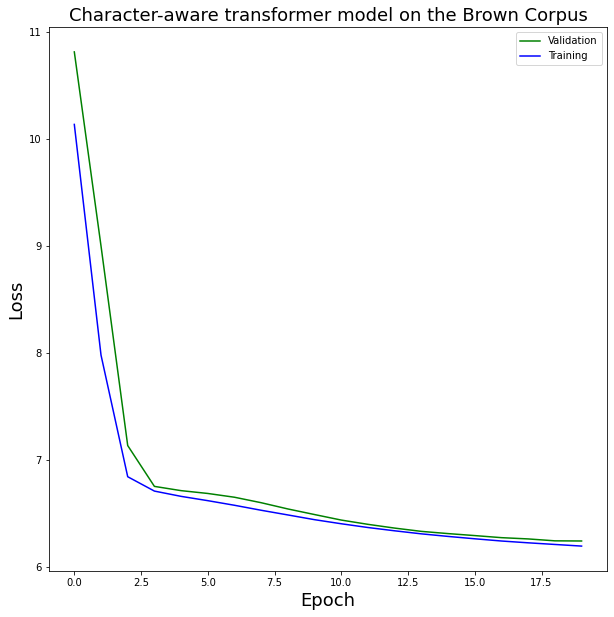

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(range(N),val_loss,label="Validation",color="green")
plt.plot(range(N),train_loss,label="Training",color="blue")

plt.xlabel("Epoch",fontsize=18)
plt.ylabel("Loss",fontsize=18)
plt.title("Character-aware "+architecture+" model on the "+corpus+" Corpus",fontsize=18)
plt.legend()
plt.show()

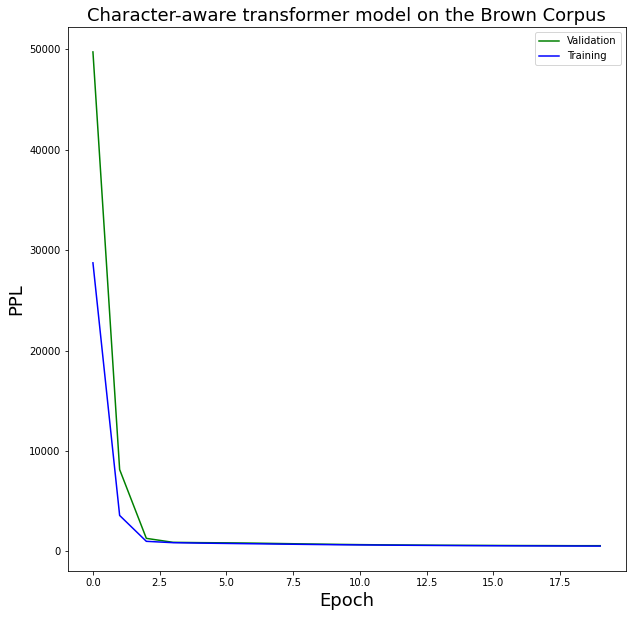

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(range(N),val_ppl,label="Validation",color="green")
plt.plot(range(N),train_ppl,label="Training",color="blue")

plt.xlabel("Epoch",fontsize=18)
plt.ylabel("PPL",fontsize=18)
plt.title("Character-aware "+architecture+" model on the "+corpus+" Corpus",fontsize=18)
plt.legend()
plt.show()